# Self-supervised contrastive learning for leukocyte encoding

In this script, we'll used the <a href="https://ieeexplore.ieee.org/abstract/document/6544926">NNCLR</a> architecture to train a deep learning backbone to encode images of leukocytes into a discriminative latent space.

Below are the steps we perform:

1. Load required libraries
1. Declare hyperparameters used during training
1. Load unlabeled data (for training the encoder)
1. Load labeled data (for probing the encoder's training)
1. Create the generators and augmentation pipeline used for training/testing the encoder
1. Create and train the encoder and the the NNCLR architecture
1. Encode labeled images and save results

## 1. Load required libraries

Requirements are:
- imgaug 0.4.0
- matplotlib 3.3.4
- numpy 1.18.5
- pandas 1.1.5
- Pillow 8.1.0
- seaborn 0.11.2
- scikit-learn 0.24.1
- scipy 1.7.3
- tensorflow 2.3.2
- tqdm 4.56.2
- umap-learn 0.5.3

In [1]:
# used for listing/loading images & files
import os

# basic data manipulation libraries
import numpy as np
import pandas as pd

# deep learning framework
import tensorflow as tf

# image manipulation libraries
import imgaug as ia
from imgaug import augmenters as iaa
import PIL
from PIL import ImageFile

# figures
from matplotlib import pyplot as plt

import time

# machine learning libraries
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

## 2. Declare hyperparameters used during training

In this section we will declare the various hyperparameters that will be used for training the encoder. See each related section for further details on each variable.

In [2]:
CROP_SIZE = 128 # size of crops for pretext task in self-supervised training
FULL_SIZE = 272 # size of images during inference ; this will ensure that all cell images are the same size (should be larger than the largest image's width & height)

BATCH_SIZE = 8 # batch size used during self supervised training
SEED = 43 # seed for random reproducibility

ENCODER_BACKBONE = "vgg16" # either "vgg16", "resnet50", "inceptionv3" or "efficientnetb4"
ENCODER_GLOBAL_POOLING = "avg" # either "avg" or "max"

# path containing the unlabeled images
UNLABELED_IMAGES_PATH = "C:/VEXAS/data/PN/unlabeled"
# should be structured as :
# rootpath/
# ├── image1.png
# ├── image2.png
# ...
# └── imagen.png
# i.e. all images, unsorted in the root path UNLABELED_IMAGES_PATH is pointing towards

# possible labels for our test data, i.e. pathology
LABELS = ("VEXAS","UBA1-WT","MDS")

# path containing the labeled images
LABELED_IMAGES_PATH = "C:/VEXAS/data/PN/labeled"
# rootpath/
# ├── VEXAS/                      <--- folder containing 1 subfolder for each unique VEXAS patient
# │   ├── VEXAS[1]                <--- folder containing 1 subfolder for each unique sample for this VEXAS patient
# │   │   ├── vexasA              <--- example of patient's sample folder, containing N cell images
# │   │   │   ├── vexasA1.png
# │   │   │   ├── vexasA2.png
# │   │   │   └── vexasA3.png
# │   │   └── vexasB
# │   │       ├── vexasB1.png
# │   │       └── vexasB2.png
# │   └── VEXAS[2]
# │       ├── vexasC
# │       │   ├── vexasC1.png
# │       │   └── vexasC2.png
# │       └── vexasD
# │           ├── vexasD1.png
# │           ├── vexasD2.png
# │           └── vexasD3.png
# ├── UBA1-WT/                    <--- the UBA1-WT and MDS folders should have the same architecture as the VEXAS folder,              <--- folder containing 1 subfolder for each unique VEXAS patient
# │   └── ...                          i.e., 1 subfolder per unique patient, containing 1 subfolder per unique sample,
# └── MDS/                             containing all images for this patient's sample
#     └── ... 

NLP_DIM = 128 # number of neurons in each dense layer of the non linear projection head (self-supervised training)
QUEUE_SIZE = 0 # the size of the queue during self-supervised training of the NNCLR (QUEUE_SIZE=0 means no queue)

# the output path for exporting the trained model and results
OUTPUT_PATH = "C:/VEXAS/out"

## 3. Load unlabeled data (for training the encoder)

First, we have to list all available unlabeled images, for self-supervised training.

In [3]:
# there are no annotations, so we simply have to list the existing unlabeled images
unlabeled_images = [os.path.join(UNLABELED_IMAGES_PATH, im) for im in os.listdir(UNLABELED_IMAGES_PATH)]

print("Unlabeled dataset size : {} images".format(len(unlabeled_images)))

Unlabeled dataset size : 16 images


## 4. Load labeled data (for probing the encoder's training)

We'll list all available labeled images, and associated metadata (patient, group and sample).

Images are stored according to a specific folder hierarchy allowing separating each group, patient and sample.

In [4]:
# for each labeled image, we'll retrieve : image path, image's owner (i.e. patient) and class (i.e. patient's pathology)
# reminder : the folder hierarchy dictates the labelling, i.e. the structure class/patient/imagefile.png
labeled_images = []
labels_patients = []
labels_groups = []
labels_samples = []

for CURRENT_GROUP in LABELS:
    for CURRENT_PATIENT in os.listdir(os.path.join(LABELED_IMAGES_PATH, CURRENT_GROUP)):
        for CURRENT_SAMPLE in os.listdir(os.path.join(LABELED_IMAGES_PATH, CURRENT_GROUP, CURRENT_PATIENT)):
            for CURRENT_IMAGE in os.listdir(os.path.join(LABELED_IMAGES_PATH, CURRENT_GROUP, CURRENT_PATIENT, CURRENT_SAMPLE)):
                labeled_images.append(os.path.join(LABELED_IMAGES_PATH, CURRENT_GROUP, CURRENT_PATIENT, CURRENT_SAMPLE, CURRENT_IMAGE))
                labels_patients.append(CURRENT_PATIENT)
                labels_groups.append(CURRENT_GROUP)
                labels_samples.append(CURRENT_SAMPLE)
            
for i, (image, patient, group, sample) in enumerate(zip(labeled_images, labels_patients, labels_groups, labels_samples)):
    print("At path: <{}>\n    Patient '{}', sample '{}', group '{}'".format(image,patient,sample,group))

At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[1]\vexasA\vexasA1.png>
    Patient 'VEXAS[1]', sample 'vexasA', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[1]\vexasA\vexasA2.png>
    Patient 'VEXAS[1]', sample 'vexasA', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[1]\vexasA\vexasA3.png>
    Patient 'VEXAS[1]', sample 'vexasA', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[1]\vexasB\vexasB1.png>
    Patient 'VEXAS[1]', sample 'vexasB', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[1]\vexasB\vexasB2.png>
    Patient 'VEXAS[1]', sample 'vexasB', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[2]\vexasC\vexasC1.png>
    Patient 'VEXAS[2]', sample 'vexasC', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[2]\vexasC\vexasC2.png>
    Patient 'VEXAS[2]', sample 'vexasC', group 'VEXAS'
At path: <C:/VEXAS/data/PN/labeled\VEXAS\VEXAS[2]\vexasD\vexasD1.png>
    Patient 'VEXAS[2]', sample 'vexasD', group 'VEXAS'


## 5. Create the generators and augmentation pipeline used for training/testing the encoder

We will need two different generators :
   
1. A generator for the pretext task, which will be responsible of loading original images, applying image augmentation and creating couples of crops for the instance discrimination task, and finally preprocess images according to the chosen backbone (e.g., normalize between -1 and 1, standardize according to the ImageNet's values...)

2. A generator for the inference, which will only be loading the images and ensuring that the encoder is fed with images of the same size

We will first define the preprocessing function used according to the chosen backbone (this preprocessing function is the one used when pre-training backbone on the ImageNet dataset, since we use transfer learning) :

In [5]:
if ENCODER_BACKBONE == "inceptionv3":
    preprocess_input_fn = tf.keras.applications.inception_v3.preprocess_input
if ENCODER_BACKBONE == "resnet50":
    preprocess_input_fn = tf.keras.applications.resnet50.preprocess_input
if ENCODER_BACKBONE == "vgg16":
    preprocess_input_fn = tf.keras.applications.vgg16.preprocess_input
if ENCODER_BACKBONE == "efficientnetb4":
    preprocess_input_fn = tf.keras.applications.efficientnet.preprocess_input

If we want to visualize images even after they have been pre-processed for feeding the encoder, we can also declare *unpreprocessing* functions that will reverse this pre-processing:

In [6]:
if ENCODER_BACKBONE == "inceptionv3":
    def unpreprocess_input(x, clip=True):
        x += 1.
        x *= 127.5
        if clip:
            x = np.minimum(255, np.maximum(0, x))
        return x.astype('uint')
if ENCODER_BACKBONE == "resnet50" or ENCODER_BACKBONE == "vgg16":
    def unpreprocess_input(x, clip=True):
        mean_rgb = [103.939, 116.779, 123.68]
        for c in range(3):
            x[...,c]+=mean_rgb[c]
        # reverse 'RGB'->'BGR', AFTER demeaning
        x = x[..., ::-1]
        if clip:
            x = np.minimum(255, np.maximum(0, x))
        return x.astype('uint')
if ENCODER_BACKBONE == "efficientnetb4":
    def unpreprocess_input(x, clip=True):
        if clip:
            x = np.minimum(255, np.maximum(0, x))
        return x.astype('uint')

Before coding the generator that will generate batches of cropped images for training the encoder, we have to declare the function that will be used for generating a unique, random crop for each image of the batch.

The first function `pretext_augmentation` takes the full size image of a cell (either PMN, monocyte or lymphocyte), applies random vertical and/or horizontal flipping and random rotation and outputs an augmented crop of the desired size.

Since this function is called using a seed, calling it twice with two different seeds on the same original image allows obtaining two different crops, for the pretext instance discrimination task.

In [7]:
def pretext_augmentation(images, crop_size, seed=None):
    if seed is not None:
        ia.seed(seed)
    seq = iaa.Sequential( # on applique une augmentation uniquement sur flip/rotation, puis on crop
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.5), # vertically flip 20% of all images
            iaa.Affine(
                rotate=(-180, 180), # rotate by -45 to +45 degrees
            ),
            iaa.CropToFixedSize(crop_size, crop_size, position='uniform'),
            iaa.PadToFixedSize(crop_size, crop_size, position='center'),
        ],
        random_order=False
    )
    return seq.augment_images(images)

We can then create a generator class, that will be used for loading and preprocessing images during training.

For each batch, the generator will load B images (B being the batch size), and will use the `pretext_augmentation` function to create two different, unique crops of each image in the batch.

Before returning the crops, the generator applies the required preprocessing to the images, depending on the function given to the `preprocess_function` argument.

In [8]:
class PretextGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images, batch_size, crop_size, preprocess_function, shuffle=True, seed=43):
        print("Pretext generator called with {} images".format(len(images)))
        # check that all files exist
        images_exist = [os.path.exists(im) for im in images]
        for im,exists in zip(images, images_exist):
            if not exists:
                print("    > Image at path <{}> does not exist".format(im))
        assert all(images_exist), "One or multiple images do not exist!"
        self.images_paths                                     = images                  # array of image paths
        self.crop_size                                        = crop_size               # crops dimensions
        self.batch_size                                       = batch_size              # batch size
        self.preprocess_function                              = preprocess_function     # preprocess function before sending to the model
        self.shuffle                                          = shuffle                 # whether or not to shuffle images
        self.seed                                             = seed                    # rng seed
        self.rng                                              = np.random.RandomState(seed)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # do nothing since processed at each new batch
        self.seed += 1
        self.indexes = np.arange(len(self.images_paths))
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data and seed for current batch
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.indexes))]
        seed = self.seed * 100000 + (index*2)
        
        # load images
        images = [np.array(PIL.Image.open(self.images_paths[k])) for k in indexes]
        
        # preprocess and augment data
        images_crops1 = pretext_augmentation(images, crop_size=self.crop_size, seed=seed)
        images_crops2 = pretext_augmentation(images, crop_size=self.crop_size, seed=seed+1)
            
        if self.preprocess_function is not None:
            images_crops1 = [self.preprocess_function(img) for img in images_crops1]
            images_crops2 = [self.preprocess_function(img) for img in images_crops2]
            
        images_crops1 = np.array(images_crops1)
        images_crops2 = np.array(images_crops2)
        
        return images_crops1, images_crops2

Finally we can instantiate the training generator:

In [9]:
train_gen = PretextGenerator(images = unlabeled_images,
                             batch_size = BATCH_SIZE,
                             crop_size = CROP_SIZE,
                             preprocess_function = preprocess_input_fn,
                             shuffle = True,
                             seed = SEED)

Pretext generator called with 16 images


We will also create a generator for inference

This generator will not alter or crop images, but instead add black padding to all images, so all cell images are the same size. This will speed up inference by allowing using a batch size higher than 1.

First, we declare the function used for adding padding to images:

In [10]:
def upsize(images, upsize):
    seq = iaa.Sequential( # on applique une augmentation uniquement sur flip/rotation, puis on crop
        [
            iaa.PadToFixedSize(upsize, upsize, position='center'),
        ],
        random_order=False
    )
    return seq.augment_images(images)

We can then create the inference generator class:

In [11]:
class InferenceGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, images, labels_group, labels_sample, batch_size, im_upsize, shuffle, preprocess_function, seed=43):
        print("Inference generator called with {} images".format(len(images)))
        images_exist = [os.path.exists(im) for im in images]
        for im,exists in zip(images, images_exist):
            if not exists:
                print("    > Image at path <{}> does not exist".format(im))
        assert all(images_exist), "One or multiple images do not exist!"
        self.images_paths        = images                  # array of image paths
        self.labels_group        = labels_group
        self.labels_sample       = labels_sample
        if self.labels_group is not None:
            self.labels_group = np.array(labels_group)
        if self.labels_sample is not None:
            self.labels_sample = np.array(labels_sample)
        self.batch_size          = batch_size              # batch size
        self.preprocess_function = preprocess_function     # preprocess function before sending to the model
        self.im_upsize           = im_upsize
        self.shuffle             = shuffle
        self.rng                 = np.random.RandomState(seed)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.images_paths) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        # do nothing since processed at each new batch
        self.indexes = np.arange(len(self.images_paths))
        if self.shuffle:
            self.rng.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data and seed for current batch
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.indexes))]
        
        # load & preprocess images
        images = [np.array(PIL.Image.open(self.images_paths[k])) for k in indexes]
        
        if self.im_upsize is not None:
            images = upsize(images, self.im_upsize)
        
        images = [self.preprocess_function(img) for img in images]
        images = np.array(images)
        
        if (self.labels_group is not None) and (self.labels_sample is not None):
            labels_group = self.labels_group[indexes,...]
            labels_sample = self.labels_sample[indexes,...]
            return images, labels_group, labels_sample
        
        return images

And instanciate the inference generator:

In [12]:
test_gen = InferenceGenerator(images=labeled_images,
                              labels_group=pd.get_dummies(labels_groups).to_numpy(),
                              labels_sample=pd.get_dummies(labels_samples).to_numpy(),
                              batch_size = BATCH_SIZE,
                              im_upsize = FULL_SIZE,
                              shuffle=False,
                              preprocess_function=preprocess_input_fn)

Inference generator called with 30 images


We can test the output of both generators :

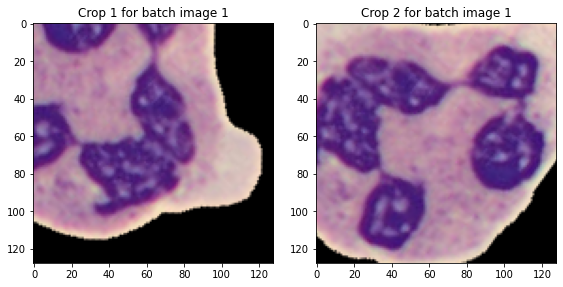

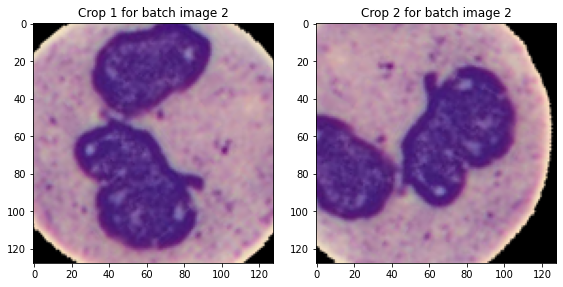

In [13]:
batch_crops1, batch_crops2 = train_gen.__getitem__(0)

for i in range(2):
    sample_crop1, sample_crop2 = batch_crops1[i], batch_crops2[i]
    
    # we'll 'unpreprocess' the image so its visualization will be understandable
    sample_crop1, sample_crop2 = unpreprocess_input(sample_crop1), unpreprocess_input(sample_crop2)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(sample_crop1)
    plt.title("Crop 1 for batch image {}".format(i+1))
    plt.subplot(1,2,2)
    plt.imshow(sample_crop2)
    plt.title("Crop 2 for batch image {}".format(i+1))
    plt.tight_layout()

In the figure above, the encoder will be trained to output encodings that are very similar for the two crops at the top and for the two crops at the bottom (i.e. from the same leukocyte), and that are very dissimilar for any of the two crops at the top and any of the two crops at the bottom (i.e. crops from different leukocytes).

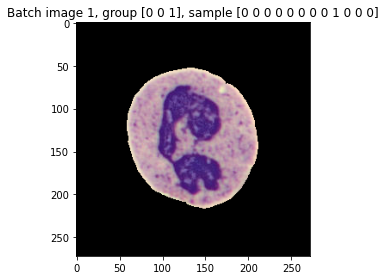

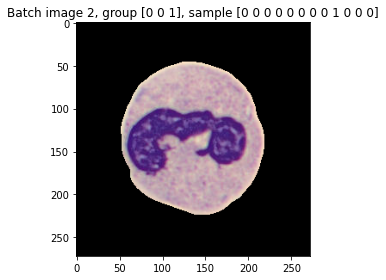

In [14]:
batch_fullsize_images, batch_labels_groups, batch_labels_samples = test_gen.__getitem__(0)

for i in range(2):
    batch_fullsize_image = batch_fullsize_images[i]
    
    # we'll 'unpreprocess' the image so its visualization will be understandable
    batch_fullsize_image = unpreprocess_input(batch_fullsize_image)

    plt.figure(figsize=(4,4))
    plt.imshow(batch_fullsize_image)
    plt.title("Batch image {}, group {}, sample {}".format(i+1,batch_labels_groups[i],batch_labels_samples[i]))
    plt.tight_layout()

In the figure above, the encoder will be used to translate those two cells to encodings; it will then be tested on its performance to discriminate (via a k-nearest neighbors algorithm) cells from patients with different groups, after partitioning by sample (i.e. two cells from the same sample must be in the same dataset, either training or test).

## 6. Create and train the encoder and the the NNCLR architecture

First, we will load the backbone architecture to instantiate our encoder model.

To accelerate training, we will also load pre-trained weights on the ImageNet dataset (images fed to the model will be preprocessed in order to respect the preprocessing that was used for pre-training the backbone architecture).

In [15]:
def getEncoder(ENCODER_BACKBONE, INPUT_SIZE):
    if ENCODER_BACKBONE == "inceptionv3":
        encoder = tf.keras.applications.inception_v3.InceptionV3(include_top = False, input_shape = (CROP_SIZE, CROP_SIZE, 3), pooling = ENCODER_GLOBAL_POOLING)
    if ENCODER_BACKBONE == "resnet50":
        encoder = tf.keras.applications.resnet50.ResNet50(include_top = False, input_shape = (CROP_SIZE, CROP_SIZE, 3), pooling = ENCODER_GLOBAL_POOLING)
    if ENCODER_BACKBONE == "vgg16":
        encoder = tf.keras.applications.vgg16.VGG16(include_top = False, input_shape = (CROP_SIZE, CROP_SIZE, 3), pooling = ENCODER_GLOBAL_POOLING)
    if ENCODER_BACKBONE == "efficientnetb4":
        encoder = tf.keras.applications.efficientnet.EfficientNetB4(include_top = False, input_shape = (CROP_SIZE, CROP_SIZE, 3), pooling = ENCODER_GLOBAL_POOLING, weights='imagenet')
    return encoder

encoder = getEncoder(ENCODER_BACKBONE = ENCODER_BACKBONE, INPUT_SIZE = CROP_SIZE)
fullsize_encoder = getEncoder(ENCODER_BACKBONE = ENCODER_BACKBONE, INPUT_SIZE = FULL_SIZE)

Then we can declare our NNCLR class that will ensure self-supervised contrastive leraning:

In [16]:
class NNCLR(tf.keras.Model):
    def __init__(
        self, encoder, projection_head_dim, temperature, queue_size,
    ):
        super(NNCLR, self).__init__()
        self.correlation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.contrastive_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.probe_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.probe_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.encoder = encoder
        self.projection_head = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(encoder.output_shape[1],)),
                tf.keras.layers.Dense(projection_head_dim, activation="relu"),
                tf.keras.layers.Dense(projection_head_dim),
            ],
            name="projection_head",
        )
        self.linear_probe = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(encoder.output_shape[1],)),
                tf.keras.layers.Dense(2)
            ],
            name="linear_probe"
        )
        self.temperature = temperature

        if queue_size>0:
            self.queue = True
            self.feature_queue = tf.Variable(
                tf.math.l2_normalize(
                    tf.random.normal(shape=(queue_size, self.projection_head.output_shape[1])), axis=1
                ),
                trainable=False,
            )
        else:
            self.queue = False
          
    def save(self,
             filepath,
             overwrite=True,
             include_optimizer=True,
             save_format=None,
             signatures=None,
             options=None):
        
        self.encoder.save(os.path.splitext(filepath)[0]+"_encoder.h5", overwrite, include_optimizer, save_format, signatures, options)
        self.projection_head.save(os.path.splitext(filepath)[0]+"_projection_head.h5", overwrite, include_optimizer, save_format, signatures, options)
        
    def save_weights(self,
                     filepath,
                     overwrite=True,
                     save_format=None,
                     options=None):
        self.encoder.save_weights(os.path.splitext(filepath)[0]+"_encoder.h5", overwrite, save_format, options)
        self.projection_head.save_weights(os.path.splitext(filepath)[0]+"_projection_head.h5", overwrite, save_format, options)
        
    def load_weights(self,
                     filepath,
                     by_name=False,
                     skip_mismatch=False,
                     options=None):
        self.encoder.load_weights(os.path.splitext(filepath)[0]+"_encoder.h5", by_name, skip_mismatch, options)
        self.projection_head.load_weights(os.path.splitext(filepath)[0]+"_projection_head.h5", by_name, skip_mismatch, options)
        
    def call(self, x):
        return self.encoder(x)

    def compile(self, contrastive_optimizer, **kwargs):
        super(NNCLR, self).compile(**kwargs)
        self.contrastive_optimizer = contrastive_optimizer

    def nearest_neighbour(self, projections):
        support_similarities = tf.matmul(
            projections, self.feature_queue, transpose_b=True
        )
        nn_projections = tf.gather(
            self.feature_queue, tf.argmax(support_similarities, axis=1), axis=0
        )
        return projections + tf.stop_gradient(nn_projections - projections)

    def update_contrastive_accuracy(self, features_1, features_2):
        features_1 = tf.math.l2_normalize(features_1, axis=1)
        features_2 = tf.math.l2_normalize(features_2, axis=1)
        similarities = tf.matmul(features_1, features_2, transpose_b=True)

        batch_size = tf.shape(features_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(
            tf.concat([contrastive_labels, contrastive_labels], axis=0),
            tf.concat([similarities, tf.transpose(similarities)], axis=0),
        )

    def update_correlation_accuracy(self, features_1, features_2):
        features_1 = (
            features_1 - tf.reduce_mean(features_1, axis=0)
        ) / tf.math.reduce_std(features_1, axis=0)
        features_2 = (
            features_2 - tf.reduce_mean(features_2, axis=0)
        ) / tf.math.reduce_std(features_2, axis=0)
        
        # batch_size = tf.shape(features_1, out_type=tf.float32)[0]
        batch_size = tf.cast(tf.shape(features_1, out_type=tf.int32), tf.float32)[0]
        cross_correlation = (
            tf.matmul(features_1, features_2, transpose_a=True) / batch_size
        )

        feature_dim = tf.shape(features_1)[1]
        correlation_labels = tf.range(feature_dim)
        self.correlation_accuracy.update_state(
            tf.concat([correlation_labels, correlation_labels], axis=0),
            tf.concat([cross_correlation, tf.transpose(cross_correlation)], axis=0),
        )

    def contrastive_loss(self, projections_1, projections_2):
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)

        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
            
        if self.queue:
            similarities_1_2_1 = (
                tf.matmul(
                    self.nearest_neighbour(projections_1), projections_2, transpose_b=True
                )
                / self.temperature
            )
            similarities_1_2_2 = (
                tf.matmul(
                    projections_2, self.nearest_neighbour(projections_1), transpose_b=True
                )
                / self.temperature
            )
    
            similarities_2_1_1 = (
                tf.matmul(
                    self.nearest_neighbour(projections_2), projections_1, transpose_b=True
                )
                / self.temperature
            )
            similarities_2_1_2 = (
                tf.matmul(
                    projections_1, self.nearest_neighbour(projections_2), transpose_b=True
                )
                / self.temperature
            )
    
            loss = tf.keras.losses.sparse_categorical_crossentropy(
                tf.concat(
                    [
                        contrastive_labels,
                        contrastive_labels,
                        contrastive_labels,
                        contrastive_labels,
                    ],
                    axis=0,
                ),
                tf.concat(
                    [
                        similarities_1_2_1,
                        similarities_1_2_2,
                        similarities_2_1_1,
                        similarities_2_1_2,
                    ],
                    axis=0,
                ),
                from_logits=True,
            )
        else:
            similarities_1_2 = (
                tf.matmul(
                    projections_1, projections_2, transpose_b=True
                )
                / self.temperature
            )
            similarities_2_1 = (
                tf.matmul(
                    projections_2, projections_1, transpose_b=True
                )
                / self.temperature
            )
    
            loss = tf.keras.losses.sparse_categorical_crossentropy(
                tf.concat(
                    [
                        contrastive_labels,
                        contrastive_labels,
                    ],
                    axis=0,
                ),
                tf.concat(
                    [
                        similarities_1_2,
                        similarities_2_1,
                    ],
                    axis=0,
                ),
                from_logits=True,
            )

        if self.queue:
            self.feature_queue.assign(
                tf.concat([projections_1, self.feature_queue[:-batch_size]], axis=0)
            )
            
        return tf.reduce_mean(loss)

    def train_step(self, data):
        unlabeled_crops1, unlabeled_crops2 = data

        with tf.GradientTape() as tape:
            features_1 = self.encoder(unlabeled_crops1)
            features_2 = self.encoder(unlabeled_crops2)
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.update_contrastive_accuracy(features_1, features_2)
        self.update_correlation_accuracy(features_1, features_2)

        return {
            "c_loss": contrastive_loss,
            "c_acc": self.contrastive_accuracy.result(),
            "r_acc": self.correlation_accuracy.result(),
        }

We can thus instantiate the NNCLR class:

In [17]:
ssl_trainer = NNCLR(encoder=encoder, projection_head_dim=NLP_DIM, temperature=.07, queue_size=QUEUE_SIZE)
ssl_trainer.compile(contrastive_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

As discussed above, we'll be using a probing algorithm for checking the discriminative capacity of encodings output by the model, at the end of each epoch. We'll use a custom keras callback to perform this:

In [18]:
class ProbeCallback(tf.keras.callbacks.Callback):
    def __init__(self, upscale_encoder, test_gen, n_batches, cv=10, seed=44):
        super(ProbeCallback, self)
        self.upscale_encoder = upscale_encoder
        self.test_gen = test_gen
        self.n_batches = n_batches
        self.cv = cv
        self.seed = seed
        
    def _samples_bootstraps(self, labels_sample, labels_group, seed):
        # bootstrap
        labels_sample_notonehot = np.argmax(labels_sample, axis=1)
        labels_group_notonehot = np.argmax(labels_group, axis=1)
        # partition patients with respect to their group
        unique_samples = np.unique(labels_sample_notonehot)
        unique_samples_group = np.array([labels_group_notonehot[labels_sample_notonehot==smp][0] for smp in unique_samples])
        bootstrap_train = resample(unique_samples, replace=False, n_samples=int(len(unique_samples)/2), random_state=seed, stratify=unique_samples_group)
        bootstrap_test = np.setdiff1d(unique_samples, bootstrap_train)
        # convert to indices
        bootstrap_train_indices = np.isin(labels_sample_notonehot, bootstrap_train)
        bootstrap_test_indices = np.isin(labels_sample_notonehot, bootstrap_test)
        # return
        return bootstrap_train_indices, bootstrap_test_indices
        
    def on_epoch_end(self, epoch, logs={}):
        start_time = time.time()
        
        # transfer weights from trained model to upscale encoder
        self.upscale_encoder.set_weights(self.model.encoder.get_weights())
        # self.upscale_encoder.compile(loss=None, metrics=None)
        
        encodings = []
        labels_group = []
        labels_sample = []
        if self.n_batches is not None:
            n_batches = self.n_batches
        else:
            n_batches = self.test_gen.__len__()
        for i in range(n_batches):
            image, label_group, label_sample = test_gen.__getitem__(i)
            encoding = self.upscale_encoder.predict(image)
            encodings.append(encoding)
            labels_group.append(label_group)
            labels_sample.append(label_sample)
            
        encodings = np.concatenate(encodings, axis=0)
        encodings = normalize(encodings, norm='l2', axis=1)
        labels_group = np.concatenate(labels_group, axis=0)
        labels_sample = np.concatenate(labels_sample, axis=0)
        
        # run knn with 10-fold cv
        knn_model = KNeighborsClassifier(n_neighbors=5)
        accuracies = []
        for i in range(self.cv):
            bootstrap_train, bootstrap_test = self._samples_bootstraps(labels_sample=labels_sample, labels_group=labels_group, seed=i)
            knn_model.fit(encodings[bootstrap_train,...], labels_group[bootstrap_train,...])
            predictions = knn_model.predict(encodings[bootstrap_test,...])
            acc = np.sum(np.argmax(labels_group[bootstrap_test,...], axis=1) == np.argmax(predictions, axis=1)) / bootstrap_test.shape[0]
            accuracies.append(acc)
        mean_acc = np.mean(accuracies)
        logs['p_acc'] = mean_acc
        
        print("Mean probing accuracy for epoch {}: {:.3f} [computed in {:.0f}s]".format(epoch+1, mean_acc, time.time()-start_time))
       

In [19]:
probe_callback = ProbeCallback(fullsize_encoder, test_gen, n_batches = None, cv=10, seed=SEED)

We'll also use various callbacks for saving the model after each epoch and early stopping training if loss stagnates:

In [20]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(OUTPUT_PATH, "model.h5"), monitor='c_loss', save_best_only=True, save_weights_only=False),
             tf.keras.callbacks.EarlyStopping(monitor='c_loss', patience=5, min_delta=1e-3),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='c_loss', factor=.5, patience=3, min_lr=1e-5, min_delta=1e-3),
             probe_callback]

Finally, we can train our encoder:

In [21]:
# we only use 10 epochs in order to speed up training (for demonstration)
# however, due to the early stopping callback, we should leave an unattainable number of epochs (e.g. 1000)
ssl_trainer.fit(train_gen,
                epochs = 10,
                callbacks = callbacks,
                verbose = 1)

Epoch 1/10
2/2 [==============================] - ETA: 0s - c_loss: 1.2551 - c_acc: 0.7656 - r_acc: 0.0146WARNING:tensorflow:Model was constructed with shape (None, 128, 128, 3) for input Tensor("input_2:0", shape=(None, 128, 128, 3), dtype=float32), but it was called on an input with incompatible shape (None, 272, 272, 3).
Mean probing accuracy for epoch 1: 0.217 [computed in 6s]
2/2 [==============================] - 9s 5s/step - c_loss: 1.2146 - c_acc: 0.7500 - r_acc: 0.0146
Epoch 2/10
2/2 [==============================] - 10s 5s/step - c_loss: 0.9599 - c_acc: 0.8750 - r_acc: 0.0208
Epoch 3/10
2/2 [==============================] - 11s 5s/step - c_loss: 0.6217 - c_acc: 0.8542 - r_acc: 0.0234
Epoch 4/10
2/2 [==============================] - 10s 5s/step - c_loss: 0.7867 - c_acc: 0.8958 - r_acc: 0.0238
Epoch 5/10
2/2 [==============================] - 10s 5s/step - c_loss: 0.7149 - c_acc: 0.8958 - r_acc: 0.0306
Epoch 6/10
2/2 [==============================] - 10s 5s/step - c_loss: 0

## 7. Encode labeled images and save results

Once the model is trained, we can predict use it to translate labeled images to encodings:

In [22]:
 # predict on labeled images
encoded_images = encoder.predict(test_gen, verbose=1)

4/4 [==============================] - 5s 1s/step


In [23]:
encoded_images.shape

(30, 512)

We'll store metadata (patient, sample, group) for each encoding into a pandas DataFrame:

In [24]:
encodings_metadata = pd.DataFrame(dict(PATIENT=labels_patients, SAMPLE=labels_samples, GROUP=labels_groups))

encodings_metadata

,PATIENT,SAMPLE,GROUP
0,VEXAS[1],vexasA,VEXAS
1,VEXAS[1],vexasA,VEXAS
2,VEXAS[1],vexasA,VEXAS
3,VEXAS[1],vexasB,VEXAS
4,VEXAS[1],vexasB,VEXAS
5,VEXAS[2],vexasC,VEXAS
6,VEXAS[2],vexasC,VEXAS
7,VEXAS[2],vexasD,VEXAS
8,VEXAS[2],vexasD,VEXAS
9,VEXAS[2],vexasD,VEXAS


And finally save the encodings and associated metadata to disk:

In [25]:
encodings_metadata.to_csv(os.path.join(OUTPUT_PATH, "metadata.csv"), index=False)

np.save(os.path.join(OUTPUT_PATH, "encodings.npy"), encoded_images)

<strong>Note:</strong> If we cant to encode other leukocyte images, for instance for testing the encoder discriminative capacity on leukocytes with known visible morphological features (e.g. hypo/hyper- segmentation and/or granulation, for PMN), we can load those new images and annotations and recall a new `InferenceGenerator` with those:

In [ ]:
# create the new inference generator based on new
# images: ___NEW_TEST_IMAGES___
# associated metadata: ___NEW_TEST_IMAGES_ANNOTATIONS___
new_images_gen = InferenceGenerator(images=___NEW_TEST_IMAGES___,
                                    labels_group=___NEW_TEST_IMAGES_ANNOTATIONS___,
                                    labels_sample=np.arange(___NEW_TEST_IMAGES___.shape[0]),
                                    batch_size = BATCH_SIZE,
                                    im_upsize = FULL_SIZE,
                                    shuffle=False,
                                    preprocess_function=preprocess_input_fn)

And then used the steps described above to encode those images, create a DataFrame for storing metadata and export both encodings and metadata:

In [ ]:
# encode new test iamges
new_encodings = encoder.predict(test_gen, verbose=1)
# save new encodings
new_encodings.to_csv(os.path.join(OUTPUT_PATH, "new_metadata.csv"), index=False)

# store new metadata into a DataFrame
new_metadata = pd.DataFrame(dict(GROUP=___NEW_TEST_IMAGES_ANNOTATIONS___))
# save new metadata
np.save(os.path.join(OUTPUT_PATH, "new_encodings.npy"), new_encodings)